In [1]:
import igraph
import matplotlib.pyplot as plt
import numpy as np
from os import path
import pandas as pd
import seaborn as sns
from selfregulation.utils.utils import get_behav_data
from sklearn.decomposition import FactorAnalysis
from sklearn.model_selection import KFold
from selfregulation.utils.r_to_py_utils import GPArotation, missForest, psychFA
from fancyimpute import SoftImpute
%matplotlib inline

Using TensorFlow backend.


# Calculate best number of components based on CV ML (SKlearn)

### Load Data

Load both cleaned and imputed data. Set up a helper function to quickly impute data within the Kfold split. Can't use data where imputation was performed over the whole dataset as there will be data leakage between training and test.

In [2]:
# using for speed, for the time being
def SoftImpute_df(data):
    imputed_mat = SoftImpute(verbose=False).complete(data)
    return pd.DataFrame(data=imputed_mat, columns=data.columns, index=data.index)

In [3]:
# load data
data = get_behav_data(file = 'taskdata_clean.csv', full_dataset = True)
# imputed data
imputed_data = get_behav_data(file = 'meaningful_variables_imputed.csv')
imputed_task_data = get_behav_data(file = 'taskdata_imputed.csv')
imputed_survey_data = imputed_data.drop(imputed_task_data.columns, axis = 1)
imputed_datasets = {'survey': imputed_survey_data, 'task': imputed_task_data, 'complete': imputed_data}
# cleaned data 
cleaned_data = get_behav_data( file = 'meaningful_variables_clean.csv')
cleaned_task_data = get_behav_data( file = 'taskdata_clean.csv')
cleaned_survey_data = cleaned_data.drop(cleaned_task_data.columns, axis = 1)
cleaned_datasets = {'survey': cleaned_survey_data, 'task': cleaned_task_data, 'complete': cleaned_data}

results = {'survey': {}, 'task': {}, 'complete': {}}

Getting datasets...:
 /home/ian/Experiments/expfactory/Self_Regulation_Ontology/Data/Discovery_01-31-2017
 /home/ian/Experiments/expfactory/Self_Regulation_Ontology/Data/Validation_01-31-2017
Getting datasets...:
 /home/ian/Experiments/expfactory/Self_Regulation_Ontology/Data/Discovery_01-31-2017
Getting datasets...:
 /home/ian/Experiments/expfactory/Self_Regulation_Ontology/Data/Discovery_01-31-2017
Getting datasets...:
 /home/ian/Experiments/expfactory/Self_Regulation_Ontology/Data/Discovery_01-31-2017
Getting datasets...:
 /home/ian/Experiments/expfactory/Self_Regulation_Ontology/Data/Discovery_01-31-2017


### Determine optimal number of factors
Two methods

Sklearn using cross-validated prediction
R's Psych package looking for best fitting model across all the data, penalized for complexity (BIC)

Dataset: survey
Best Component:  9
Dataset: task
Best Component:  5
Dataset: complete
Best Component:  6


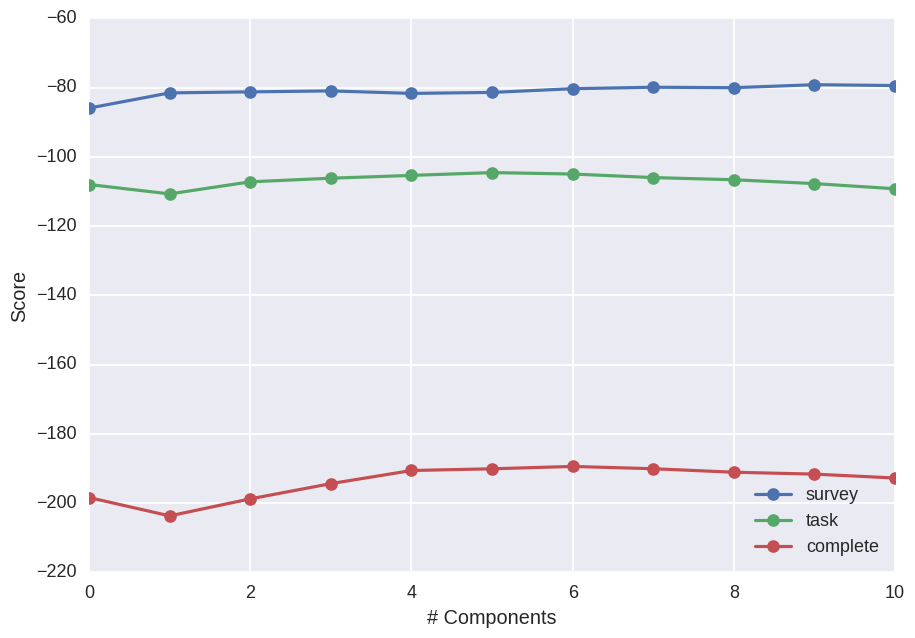

In [103]:
def CV_optimal_components(data, cv):
    # find best number of components
    n_components = range(1,12)
    best_c = 0
    component_scores = []
    for c in n_components:
        fa=FactorAnalysis(c)
        scores = []
        # cross-validate fit across different train/test splits
        for train_index, test_index in kf.split(data.values):
            data_train, data_test = data.iloc[train_index], \
                                    data.iloc[test_index]
            # Impute (replace with missForest later)
            imputed_train = SoftImpute_df(data_train)
            imputed_test = SoftImpute_df(data_test)
            # fit model on training
            fa.fit(imputed_train)
            # score on test set
            scores.append(fa.score(imputed_test))
        #average score across kfolds
        score = np.mean(scores)
        component_scores.append(score)
    best_c = np.argmax(component_scores)
    print('Best Component: ', best_c)
    return best_c, component_scores

kf = KFold(n_splits = 4)
for label,data in cleaned_datasets.items():
    print('Dataset: %s' % label)
    best_c, scores= CV_optimal_components(data, kf)
    results[label]['sklearn_best_c'] = best_c
    results[label]['CV_scores'] = scores
    
for score in [d['CV_scores'] for d in results.values()]:
    plt.plot(range(len(score)),score, '-o')
plt.legend(results.keys(), loc = 'best')
plt.xlabel('# Components')
plt.ylabel('Score')

### Calculate best number of components using BIC (R Psych package)

Dataset: survey
Best Component:  4
Dataset: task
Best Component:  3
Dataset: complete
Best Component:  2


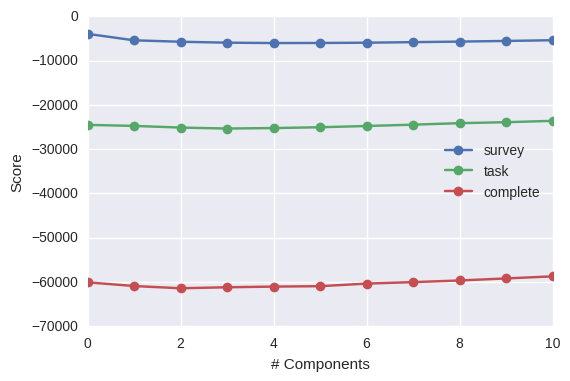

In [5]:
def BIC_optimal_components(data):
    BICs = []
    outputs = []
    n_components = range(1,12)
    for c in n_components:
        fa, output = psychFA(data, c, method='ml')
        BICs.append(output['BIC'])
        outputs.append(output)
    best_c = np.argmin(BICs)
    print('Best Component: ', best_c)
    return best_c, BICs

for label,data in imputed_datasets.items():
    print('Dataset: %s' % label)
    best_c, BICs = BIC_optimal_components(data)
    results[label]['psych_best_c'] = best_c
    results[label]['psych_BICs'] = BICs
    
for bic in [d['psych_BICs'] for d in results.values()]:
    plt.plot(range(len(bic)),bic, '-o')
plt.legend(results.keys(), loc = 'best')
plt.xlabel('# Components')
plt.ylabel('Score')

# Interpret Factor Analysis Solutions
Above we found that the best number of components were as follows:

**SKlearn**:

Task: {{results['task']['sklearn_best_c']}}

Survey: {{results['survey']['sklearn_best_c']}}

Complete: {{results['complete']['sklearn_best_c']}}

**Psych**:

Task: {{results['task']['psych_best_c']}}

Survey: {{results['survey']['psych_best_c']}}

Complete: {{results['complete']['psych_best_c']}}

Because psych performs rotation, is more widely used, we will use that as our main analysis. All analyses will be repeated with the sklearn pipeline as well. First we will look at the best number of components, then we will look at the solution at each dimensionality and plot the relationships between dimensions

## Interpret best components (Psych)

Note: percent variance explained is very low for all these models...

### Complete

For EFA using the psych package, the optimal factor structure for the complete dataset settled on 2 dimensions as optimal.

In [105]:
complete_results = results['complete']
best_c = complete_results['psych_best_c']
data = imputed_datasets['complete']
fa, output = psychFA(data, best_c)

In [106]:
### Print top variables for each factor
def print_top_factors(fa_output, n = 4):
    # number of variables to display
    loading_df = pd.DataFrame(fa_output['loadings'], index=data.columns)
    for i,column in loading_df.iteritems():
        sort_index = np.argsort(abs(column))[::-1] # descending order
        top_vars = column[sort_index][0:n]
        print('\nFACTOR %s' % i)
        print(top_vars)
    return loading_df
        
loading_df = print_top_factors(output, 6)
loading_df.columns = ["Self Regulation","Intelligence"]
loading_df.loc[:,'task'] = [i.split('.')[0] for i in loading_df.index]


FACTOR 0
self_regulation_survey.control                      0.896113
brief_self_control_survey.self_control              0.884745
grit_scale_survey.grit                              0.790530
five_facet_mindfulness_survey.act_with_awareness    0.771786
upps_impulsivity_survey.negative_urgency           -0.770199
upps_impulsivity_survey.lack_of_perseverance       -0.759485
Name: 0, dtype: float64

FACTOR 1
dot_pattern_expectancy.hddm_drift             0.669546
directed_forgetting.hddm_drift                0.629015
choice_reaction_time.hddm_drift               0.623396
dot_pattern_expectancy.dprime                 0.614005
time_perspective_survey.present_hedonistic   -0.584864
upps_impulsivity_survey.sensation_seeking    -0.572542
Name: 1, dtype: float64


I won't spend a lot of time interpreting these two massive factors. But since there are only two it's easy to plot them and look at the distribution of items. Colors relate to different measures. We can see that tasks only measure one of these factors while surveys cover a bit more

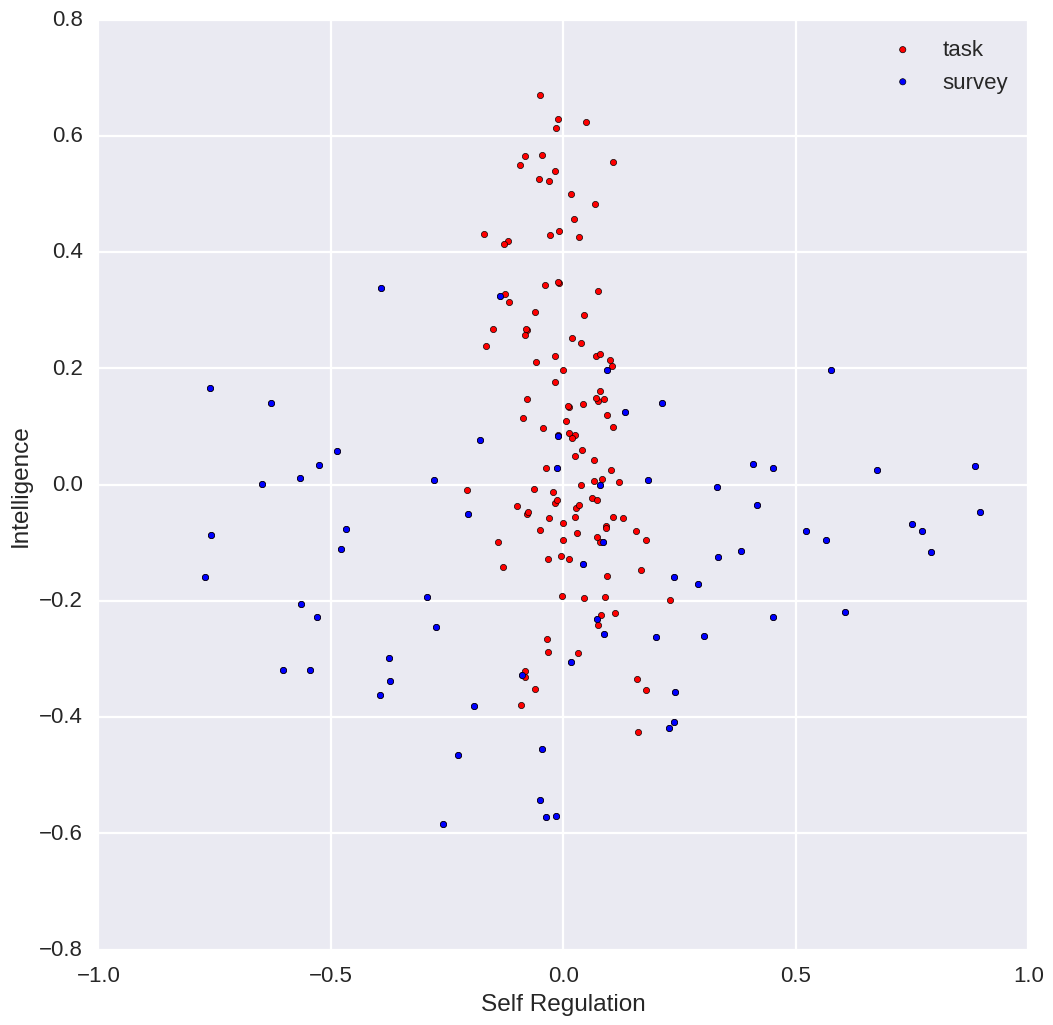

In [113]:
sns.set_context('poster')
colors=['red' if 'survey' in task else 'blue' for task in loading_df.task]
plt.figure(figsize=[12,12])
task_index = loading_df.filter(regex='^((?!drift).)*$',axis=0).index
survey_index = loading_df.filter(regex='survey',axis=0).index
plt.scatter(loading_df.ix[:,0],loading_df.ix[:,1],c='red',label='task')
plt.scatter(loading_df.ix[survey_index,0],
            loading_df.ix[survey_index,1],c='blue',label='survey')
plt.xlabel('Self Regulation')
plt.ylabel('Intelligence')
plt.legend(['task','survey'])
#sns.jointplot('Self Regulation', 'Intelligence', data=loading_df)

### Task

In [86]:
task_results = results['task']
best_c = task_results['psych_best_c']
data = imputed_datasets['task']
fa, output = psychFA(data, best_c)

In [87]:
### Print top variables for each factor
def print_top_factors(fa_output, n = 4):
    # number of variables to display
    loading_df = pd.DataFrame(fa_output['loadings'], index=data.columns)
    for i,column in loading_df.iteritems():
        sort_index = np.argsort(abs(column))[::-1] # descending order
        top_vars = column[sort_index][0:n]
        print('\nFACTOR %s' % i)
        print(top_vars)
    return loading_df
        
loading_df = print_top_factors(output, 6)


FACTOR 0
dot_pattern_expectancy.hddm_drift         0.761510
dot_pattern_expectancy.dprime             0.747329
choice_reaction_time.hddm_drift           0.716124
motor_selective_stop_signal.hddm_drift    0.672435
simon.hddm_drift                          0.649660
recent_probes.hddm_drift                  0.626890
Name: 0, dtype: float64

FACTOR 1
kirby.hyp_discount_rate_large.logTr               0.889951
kirby.hyp_discount_rate_medium.logTr              0.884591
kirby.hyp_discount_rate_small.logTr               0.875107
discount_titrate.percent_patient                 -0.804391
bickel_titrator.hyp_discount_rate_medium.logTr    0.698799
bickel_titrator.hyp_discount_rate_small.logTr     0.630714
Name: 1, dtype: float64

FACTOR 2
stop_signal.SSRT_low                      0.947267
stop_signal.SSRT_high                     0.782637
motor_selective_stop_signal.SSRT          0.558816
simon.hddm_non_decision                   0.479755
stim_selective_stop_signal.SSRT           0.446603
choice_

### Histogram of factor loadings and plot of histogram relationship
We can see that factors 4 and 5 are really just pulling from a few variables. They are really "task" factors - tapping discounting tasks and the ART task respectively. The CCT Hot "number of cards chosen" maps onto factor 5, but to a far smaller extent

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f85426dcda0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f8552089be0>]], dtype=object)

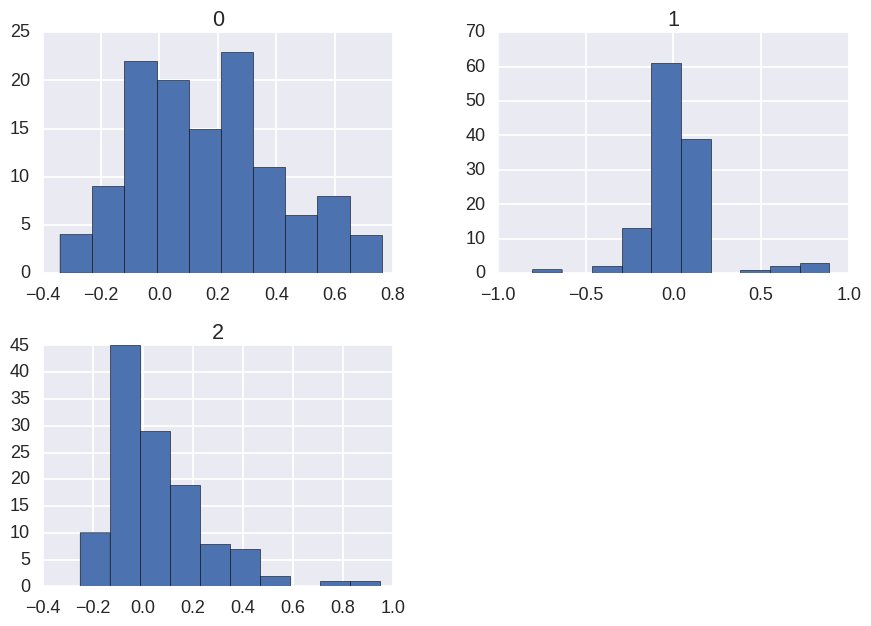

In [88]:
sns.set_context('talk')
loading_df.hist()

The factors are roughly orthogonal. Orthogonality wasn't enforced, and factors were rotated using "oblimin"

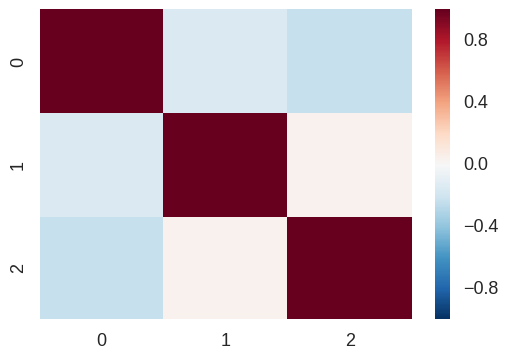

In [89]:
plt.figure(figsize=(6,4))
sns.heatmap(loading_df.corr())

### Interpretation/Naming of Factors 

Factor 0: Speed of Processing (Drift)

Factor 1: Memory/Abstraction

Factor 2: Stimulus Encoding Time (Non-Decision)

Factor 3: Response Caution (Threshold)

Factor 4: Dicount Rate

Factor 5: Risk Taking

## Do the same for all other dimensionalities

In [90]:
factor_names = {}

**One Factor**

Factor 0: {{factor_names[1][0]}}


In [91]:
fa, output = psychFA(data, 1)
loading_df = print_top_factors(output,4)
factor_names[1] = ['CogAblty']


FACTOR 0
stop_signal.SSRT_low     -0.865740
stop_signal.SSRT_high    -0.767396
threebytwo.hddm_drift     0.519584
stop_signal.hddm_drift    0.504896
Name: 0, dtype: float64


**Two Factors**

Factor 0: {{factor_names[2][0]}}

Factor 1: {{factor_names[2][1]}}

In [92]:
fa, output = psychFA(data, 2)
loading_df = print_top_factors(output, 6)
factor_names[2] = ['Intelligence','Encoding Time']


FACTOR 0
kirby.hyp_discount_rate_medium.logTr   -0.666236
threebytwo.hddm_drift                   0.663736
discount_titrate.percent_patient        0.628930
ravens.score                            0.622710
kirby.hyp_discount_rate_large.logTr    -0.622110
dot_pattern_expectancy.hddm_drift       0.602764
Name: 0, dtype: float64

FACTOR 1
stop_signal.SSRT_low                0.928790
stop_signal.SSRT_high               0.824141
motor_selective_stop_signal.SSRT    0.583231
stim_selective_stop_signal.SSRT     0.476034
simon.hddm_non_decision             0.430406
simple_reaction_time.avg_rt         0.410648
Name: 1, dtype: float64


**Three Factors**

Factor 0: {{factor_names[3][0]}}

Factor 1: {{factor_names[3][1]}}

Factor 2: {{factor_names[3][2]}}

In [93]:
fa, output = psychFA(data, 3)
loading_df = print_top_factors(output, 6)
factor_names[3] = ['Drift','Dicount','Encoding Time']


FACTOR 0
dot_pattern_expectancy.hddm_drift         0.761510
dot_pattern_expectancy.dprime             0.747329
choice_reaction_time.hddm_drift           0.716124
motor_selective_stop_signal.hddm_drift    0.672435
simon.hddm_drift                          0.649660
recent_probes.hddm_drift                  0.626890
Name: 0, dtype: float64

FACTOR 1
kirby.hyp_discount_rate_large.logTr               0.889951
kirby.hyp_discount_rate_medium.logTr              0.884591
kirby.hyp_discount_rate_small.logTr               0.875107
discount_titrate.percent_patient                 -0.804391
bickel_titrator.hyp_discount_rate_medium.logTr    0.698799
bickel_titrator.hyp_discount_rate_small.logTr     0.630714
Name: 1, dtype: float64

FACTOR 2
stop_signal.SSRT_low                      0.947267
stop_signal.SSRT_high                     0.782637
motor_selective_stop_signal.SSRT          0.558816
simon.hddm_non_decision                   0.479755
stim_selective_stop_signal.SSRT           0.446603
choice_

**Four Factors**

Factor 0: {{factor_names[4][0]}}

Factor 1: {{factor_names[4][1]}}

Factor 2: {{factor_names[4][2]}}

Factor 3: {{factor_names[4][3]}}

In [94]:
fa, output = psychFA(data, 4)
loading_df = print_top_factors(output, 4)
factor_names[4] = ['Drift','Encoding Time','Discount','Mem/Unclear']


FACTOR 0
choice_reaction_time.hddm_drift      0.732026
stop_signal.hddm_drift               0.706094
dot_pattern_expectancy.hddm_drift    0.688239
simon.hddm_drift                     0.685929
Name: 0, dtype: float64

FACTOR 1
simon.hddm_non_decision        0.657403
stroop.hddm_non_decision       0.550539
simple_reaction_time.avg_rt    0.535448
stop_signal.SSRT_low           0.514006
Name: 1, dtype: float64

FACTOR 2
kirby.hyp_discount_rate_small.logTr     0.920292
kirby.hyp_discount_rate_medium.logTr    0.870301
kirby.hyp_discount_rate_large.logTr     0.856427
discount_titrate.percent_patient       -0.822039
Name: 2, dtype: float64

FACTOR 3
adaptive_n_back.hddm_drift                             0.579545
angling_risk_task_always_sunny.keep_adjusted_clicks    0.577705
adaptive_n_back.mean_load                              0.568220
tower_of_london.avg_move_time                         -0.519063
Name: 3, dtype: float64


**Five Factors**

Factor 0: {{factor_names[5][0]}}

Factor 1: {{factor_names[5][1]}}

Factor 2: {{factor_names[5][2]}}

Factor 3: {{factor_names[5][3]}}

Factor 4: {{factor_names[5][4]}}

In [95]:
fa, output = psychFA(data, 5)
loading_df = print_top_factors(output, 6)
factor_names[5] = ['Drift','Encoding Time','Mem/Unclear','Discount','Thresh']


FACTOR 0
choice_reaction_time.hddm_drift      0.779790
dot_pattern_expectancy.hddm_drift    0.779331
dot_pattern_expectancy.dprime        0.763905
shape_matching.hddm_drift            0.675388
simon.hddm_drift                     0.656310
directed_forgetting.hddm_drift       0.644338
Name: 0, dtype: float64

FACTOR 1
stop_signal.SSRT_low                             0.674433
stop_signal.SSRT_high                            0.596682
motor_selective_stop_signal.SSRT                 0.581937
simon.hddm_non_decision                          0.573390
stim_selective_stop_signal.SSRT                  0.573056
motor_selective_stop_signal.hddm_non_decision    0.515042
Name: 1, dtype: float64

FACTOR 2
adaptive_n_back.mean_load                              0.605281
adaptive_n_back.hddm_drift                             0.604039
angling_risk_task_always_sunny.keep_adjusted_clicks    0.538635
tower_of_london.avg_move_time                         -0.531394
spatial_span.forward_span                 

**Six Factors**

Factor 0: {{factor_names[5][0]}}

Factor 1: {{factor_names[5][1]}}

Factor 2: {{factor_names[5][2]}}

Factor 3: {{factor_names[5][3]}}

Factor 4: {{factor_names[5][4]}}

Factor 5: {{factor_names[5][5]}}

In [96]:
fa, output = psychFA(data, 6)
loading_df = print_top_factors(output)
factor_names[6] = ['Drift','Encoding Time','Discount','Thresh','Mem','Risk']


FACTOR 0
choice_reaction_time.hddm_drift      0.786596
dot_pattern_expectancy.hddm_drift    0.785576
dot_pattern_expectancy.dprime        0.762951
shape_matching.hddm_drift            0.669247
Name: 0, dtype: float64

FACTOR 1
stop_signal.SSRT_low               0.680850
stop_signal.SSRT_high              0.578949
simon.hddm_non_decision            0.578239
stim_selective_stop_signal.SSRT    0.551148
Name: 1, dtype: float64

FACTOR 2
kirby.hyp_discount_rate_small.logTr     0.939002
kirby.hyp_discount_rate_medium.logTr    0.928330
kirby.hyp_discount_rate_large.logTr     0.894288
discount_titrate.percent_patient       -0.814512
Name: 2, dtype: float64

FACTOR 3
local_global_letter.hddm_thresh    0.579193
simon.hddm_thresh                  0.562590
shape_matching.hddm_thresh         0.482034
simon.simon_hddm_drift             0.476673
Name: 3, dtype: float64

FACTOR 4
adaptive_n_back.hddm_drift                        0.601726
adaptive_n_back.mean_load                         0.597590
spat

### Plot relationships between solutions at different dimensionalities

Each factor analytic solution gives us some components. By correlating the components at one level with the next, we can get a sense for how similar these components are. When we move to 3 dimensions from 2, is it the case that one of the dimensions just split? Or is there a new, non-hierarchical parcellation of the space?



In [97]:
# helper functions for plotting dimensionality relations
# compute FA with different dimensionalities and quantify similarity
def dimensional_similarity(factors, reference):
    ''' This function returns an N x M correlation matrix where N is the number
    of reference (lower dimension) factors and M is the number of higher dimension
    factors
    '''
    relation = np.corrcoef(reference.T, factors.T)
    # each row is a reference factor, each column a new factor
    relation=relation[:reference.shape[1], reference.shape[1]:]
    return relation

def construct_relational_tree(similarities, labels=None, filey=None):
    ''' Takes a list of similarities and constructs a tree graph, then plots
    '''
    G = igraph.Graph()
    layer_start = 0
    colors = ['red','blue','green','violet']*4
    for similarity in similarities:
        curr_color = colors.pop()
        origin_length = similarity.shape[0]
        target_length = similarity.shape[1]
        if len(G.vs)==0:
            G.add_vertices(origin_length)
        G.add_vertices(target_length)
        for i in range(origin_length):
            for j in range(target_length):
                G.add_edge(i+layer_start,j+origin_length+layer_start,
                           weight=abs(similarity[i,j]*5),color = curr_color)
        layer_start+=similarity.shape[0]
    layout = G.layout_reingold_tilford(root = [0])
    if labels == None:
        labels = G.vs.indices
    plot = igraph.plot(G, layout=layout, **{'inline': True, 'vertex_label': labels, 
                                            'vertex_color': 'white',
                                            'vertex_size': 50, 
                                         'edge_width':[w for w in G.es['weight']], 
                                         'edge_color': G.es['color'], 
                                            'bbox': (1000,1000), 'margin':100})
    if filey:
        plot.save(filey)
    #G.write_dot('test.dot')
    return G


In [98]:
# construct array of component similarities
similarities = []
components = np.sort(list(factor_names.keys()))
reference = None
for c in components:
    fa, output = psychFA(data,c)
    result = pd.DataFrame(output['scores'], data.index)
    if reference is not None:
        similarity = dimensional_similarity(result,reference)
        similarities.append(similarity)
    reference = result




In [100]:
# plot component similarity tree
labels = []
for c in components:
    labels+=factor_names[c]
similarity_tree = construct_relational_tree(similarities, 
                                            labels=labels, filey=path.join('Plots', 'task_graph.png'))

## Interpret best components (Sklearn)

Because it doesn't perform rotation, and doesn't give components and scores, this is difficult to interpret.

It gives "components" (analagous to the scores in FA - a n_component X feature matrix - which is roughly the weight of each feature in calculating the final scores.

If you use "fit_transform" you can then plot subjects in factor space. This uses the weight matrix (components) to transform the n_sample x n_feature matrix into an n_sample x n_component matrix

In [169]:
complete_results = results['complete']
best_c = complete_results['sklearn_best_c']
data = imputed_datasets['complete']
fa=FactorAnalysis(best_c)
fa.fit(data)
loading_df = pd.DataFrame(fa.components_.T,index=data.columns)

In [173]:
### Print top variables for each factor
def print_top_factors(loading_df, n = 4):
    for i,column in loading_df.iteritems():
        sort_index = np.argsort(abs(column))[::-1] # descending order
        top_vars = column[sort_index][0:n]
        print('\nFACTOR %s' % i)
        print(top_vars)
        
print_top_factors(loading_df, 6)



FACTOR 0
tower_of_london.planning_time      1297.565046
tower_of_london.avg_move_time       272.178532
tower_of_london.num_extra_moves      -6.300229
stop_signal.proactive_slowing         4.450927
simple_reaction_time.avg_rt           4.150643
stim_selective_stop_signal.SSRT       4.123906
Name: 0, dtype: float64

FACTOR 1
tower_of_london.avg_move_time                              523.340187
tower_of_london.planning_time                              -91.080395
simple_reaction_time.avg_rt                                  9.384219
motor_selective_stop_signal.SSRT                             5.851026
stop_signal.SSRT_low                                         5.543428
motor_selective_stop_signal.selective_proactive_control     -5.410450
Name: 1, dtype: float64

FACTOR 2
motor_selective_stop_signal.selective_proactive_control    57.273552
stim_selective_stop_signal.SSRT                           -13.598001
stop_signal.SSRT_low                                      -10.122890
motor_selecti

# Scrap

In [ ]:
for label,data in imputed_datasets.items():
    best_c = task_data['sklearn_best_c']
    # construct array of component similarities
    similarities = []
    components = range(1,best_c+2)
    reference = None
    for c in components:
        fa=FactorAnalysis(c)
        result = pd.DataFrame(fa.fit_transform(data.values), data.index)
        if c>1:
            result = GPArotation(result, method='oblimin')
        if reference is not None:
            similarity = dimensional_similarity(result,reference)
            similarities.append(similarity)
        reference = result

    # plot tree
    labels = []
    for c in np.sort(list(factor_names.keys())):
        labels+=factor_names[c]
    similarity_tree = construct_relational_tree(similarities, filey=path.join('Plots', + label +'_graph.png'))


In [ ]:
"""
# Take max for each dimension?
binarized_similarities = []
for s in similarities:
    r,c = s.shape
    binarized_similarities.append(s==np.resize(s.max(axis=1),(c,r)).T)
"""
thresh = .5
binarized_similarities = []
for s in similarities:
    binarized_similarities.append((s>thresh)*1)

## Visualization of optimal factor structure

### Sum over task variables (extrememly questionable) and then plot the relationships across tasks

In [ ]:
from plot_utils import dendroheatmap_left
# *****************************************************************************
# sum over tasks
# *****************************************************************************
tasks = np.unique([i.split('.')[0] for i in data.columns])
task_sums = {}
for task in tasks:  
    task_sums[task] = result.filter(regex=task,axis=0).sum()
task_sums = pd.DataFrame(task_sums).T
dendroheatmap = dendroheatmap_left(task_sums.T.corr())

### multidimensional scaling

In [ ]:
# *****************************************************************************
# visualize the similarity of the measurements in FA space
# *****************************************************************************

from data_preparation_utils import convert_var_names
from graph_utils import distcorr_mat
from sklearn import manifold
from sklearn.metrics import euclidean_distances
import seaborn as sns

seed = np.random.RandomState(seed=3)
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=seed,
                   dissimilarity="precomputed", n_jobs=1)

tsne = manifold.TSNE(n_components=2, random_state=seed, metric="precomputed")

# compute distances between variables
# using distance correlation
# result_distances = 1-distcorr_mat(result.T.values)
# euclidean
result_distances = euclidean_distances(result)
# transform
mds_transform = mds.fit_transform(result_distances)
tsne_transform = tsne.fit_transform(result_distances)

# plot
tasks = [i.split('.')[0] for i in result.index]
colors = sns.color_palette("husl", len(np.unique(tasks)))

fig, ax = sns.plt.subplots(figsize = (20,20))
ax.scatter(mds_transform[:,0], mds_transform[:,1])

variables = convert_var_names(list(result.index))
for i, txt in enumerate(variables):
    ax.annotate(txt, (mds_transform[i,0],mds_transform[i,1]), size = 15)
